### Import library

In [1]:
import os
import cv2
import mmcv
import argparse
import numpy as np
import matplotlib.pyplot as plt
import pycocotools.mask as maskUtils
from tqdm import tqdm
from mmdet.apis import inference_detector, init_detector

In [2]:
import tensorflow as tf

try:
    import tensorflow.python.keras as keras
except:
    import tensorflow.keras as keras

from tensorflow.keras.preprocessing import image

from tensorflow.keras.applications import ResNet50V2, ResNet101V2
from tensorflow.keras.applications import ResNet50, ResNet101, ResNet152
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import Xception

In [3]:
# Check GPU
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)
#tf.config.experimental.set_memory_growth(physical_devices[1], True)
#tf.config.experimental.set_memory_growth(physical_devices[2], True)
#tf.config.experimental.set_memory_growth(physical_devices[3], True)
#tf.config.experimental.set_memory_growth(physical_devices[4], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Define function

In [4]:
def show_result(img, result, class_names, score_thr=0.8):
    bbox_result, segm_result = result

    ###########################################
    # for one class, only keep one bbox and one segm with highest confidence
    new_bbox_result = []
    new_segm_result = []
    for bbox, segm in zip(bbox_result, segm_result):
        if len(bbox) <= 1:
            new_bbox_result.append(bbox)
            new_segm_result.append(segm)
            continue
        max_ind = np.argmax(bbox[:, -1])
        new_segm_result.append(np.asarray([segm[max_ind]]))
        new_bbox_result.append(np.asarray([bbox[max_ind]]))

    bbox_result = new_bbox_result
    segm_result = new_segm_result
    #########################################

    bboxes = np.vstack(bbox_result)
    labels = [np.full(bbox.shape[0], i, dtype=np.int32) for i, bbox in enumerate(bbox_result)]
    labels = np.concatenate(labels)

    label_candidate = [class_names[i] for i in labels]

    output_segmentation = {}
    if segm_result is not None:
        segms = mmcv.concat_list(segm_result)
        inds = np.where(bboxes[:, -1] > score_thr)[0]
        np.random.seed(42)
        try:
            color_masks = [np.random.randint(0, 256, (1, 3), dtype=np.uint8) for _ in range(max(labels) + 1)]

            for i in inds:
                color_mask = color_masks[labels[i]]
                mask = maskUtils.decode(segms[i]).astype(np.bool)

                item = img.copy()
                item[~mask] = 0

                output_segmentation[label_candidate[i]] = item
        except:
            pass

    return output_segmentation

### Setting parameters

In [5]:
model_path = './mmfashion/checkpoint/segmentation.pth'
config_file_path = './mmfashion/mmdetection/configs/mmfashion/mask_rcnn_r50_fpn_1x.py'
input_path = './EC_dataset/img/try_on/'
#input_path = './deepfashion2_datasets/train/image/'

### List testing image

In [6]:
input_img_list = [file for file in os.listdir(input_path) if ('.jpg' in file) or ('.jpeg' in file) or ('.png' in file)]
if input_img_list == []:
    print('Can not find any image in folder "inputs"...')

### Initialize model

In [7]:
model_1 = init_detector(config_file_path, model_path, device='cuda:0')
print(model_1.CLASSES)

('top', 'skirt', 'leggings', 'dress', 'outer', 'pants', 'bag', 'neckwear', 'headwear', 'eyeglass', 'belt', 'footwear', 'hair', 'skin', 'face')


### Model 1 : Segmentation

In [8]:
database = {}
for file in tqdm(input_img_list):
    img_path = os.path.join(input_path, file)
    
    # Read image
    img = cv2.imread(img_path)
    
    # Inference
    result = inference_detector(model_1, img)
    
    # Draw bbox and segmentarion mask
    output_segmentation = show_result(img, result, model_1.CLASSES, score_thr=0.6)
    
    for cate, seg_item in zip(output_segmentation.keys(), output_segmentation.values()):
        if cate == 'top':
            plot_item = cv2.cvtColor(seg_item, cv2.COLOR_BGR2RGB)
            database[img_path] = plot_item
        if cate == 'skirt' or cate == 'leggings' or cate == 'pants':
            plot_item = cv2.cvtColor(seg_item, cv2.COLOR_BGR2RGB)
            database[img_path] = plot_item
            #bottom_file_name.append(img_path)
            #bottom_seg.append(plot_item)
        #if cate == 'outer':
        #    plot_item = cv2.cvtColor(seg_item, cv2.COLOR_BGR2RGB)
        #    database_outer[img_path] = plot_item
            #outer_file_name.append(img_path)
            #outer_seg.append(plot_item)


100%|██████████| 321/321 [00:38<00:00,  8.37it/s]


### Model 2 :

In [9]:
def build_model(model_type):
    if  model_type == 'InceptionResNet':
        model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(299,299,3))
    elif model_type == 'ResNet50V2':
        model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(224,224,3))
    elif model_type == 'ResNet152':
        model = ResNet152(include_top=False, weights='imagenet', input_shape=(224,224,3))
    elif model_type == 'ResNet101V2':
        model = ResNet101V2(include_top=False, weights='imagenet', input_shape=(224,224,3))
    elif model_type == 'DenseNet':
        model = DenseNet121(include_top=False, weights='imagenet', input_shape=(224,224,3))
    elif model_type == 'Xception':
        model = Xception(include_top=False, weights='imagenet', input_shape=(299,299,3))
    else:
        sys.exit()
   
    model.trainable = False
    
    # output = keras.layers.Flatten()(model.output)
    output = keras.layers.GlobalAveragePooling2D()(model.output)

    model = keras.models.Model(name=model_type, inputs=model.inputs, outputs=output)
    # model.summary()
    return model

''' 載入圖像前處理資訊 '''
def get_pressprocess_info(model_type): 
    if  model_type == 'InceptionResNet':
        preprocess_input = keras.applications.inception_resnet_v2.preprocess_input
        img_size = (299, 299)
    elif (model_type == 'ResNet152'):
        preprocess_input = keras.applications.resnet.preprocess_input
        img_size = (224, 224)
    elif (model_type == 'ResNet50V2'or model_type == 'ResNet101V2'):
        preprocess_input = keras.applications.resnet_v2.preprocess_input
        img_size = (224, 224)
    elif model_type == 'DenseNet':
        preprocess_input = keras.applications.densenet.preprocess_input
        img_size = (224, 224)
    elif model_type == 'Xception':
        preprocess_input = keras.applications.xception.preprocess_input
        img_size = (299, 299)
             
    return preprocess_input, img_size

In [10]:
preprocess_input, input_size = get_pressprocess_info('ResNet50V2')
model_2 = build_model('ResNet50V2')

In [11]:
database_encodings = []
database_img = []
database_file = []

for file_name, img in tqdm(zip(database.keys(), database.values()), total=len(database)):
    database_file.append(file_name)
    database_img.append(img)
    
    img = cv2.resize(img, input_size)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    encoding = model_2.predict(img)[0]
        
    database_encodings.append(encoding)

100%|██████████| 306/306 [00:09<00:00, 31.29it/s]


In [12]:
def euclidean_distance(a, b):
    dist = np.linalg.norm(a - b)
    return dist

In [13]:
# ###try out cosine similarity
# def euclidean_distance(a,b):
#     vector1 = np.ndarray.flatten(a)
#     vector2 = np.ndarray.flatten(b)
#     dotprod = np.dot(a,b)
#     dist = dotprod/(np.linalg.norm(a)*np.linalg.norm(b))
#     return dist

### Input test data

Your input image !


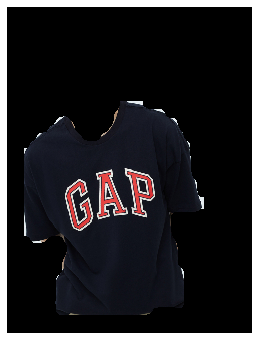

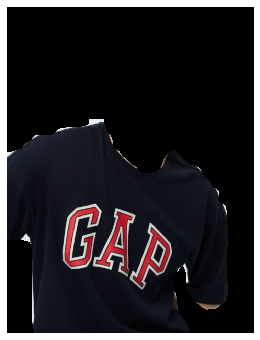

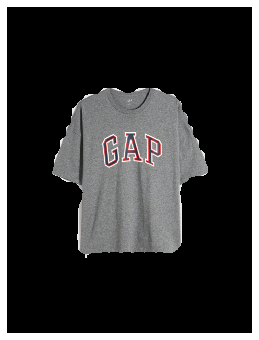

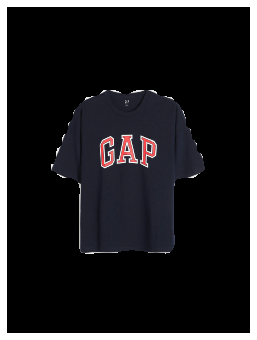

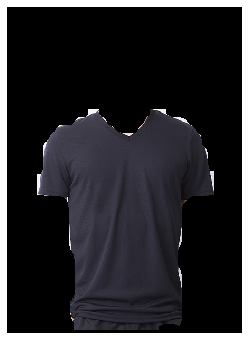

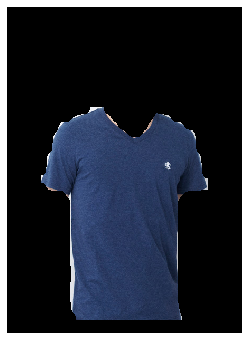

In [14]:
test = cv2.imread('./p300003.jpeg')

# Model 1
test_result = inference_detector(model_1, test)

# Draw bbox and segmentarion mask
test_segmentation = show_result(test, test_result, model_1.CLASSES, score_thr=0.6)

for cate, seg_item in zip(test_segmentation.keys(), test_segmentation.values()):
    if cate == 'top':
        seg_item = cv2.cvtColor(seg_item, cv2.COLOR_BGR2RGB)
    if cate == 'skirt' or cate == 'leggings' or cate == 'pants':
            plot_item = cv2.cvtColor(seg_item, cv2.COLOR_BGR2RGB)
    break

print('Your input image !')
plt.figure(figsize=(6, 6))
plt.axis('off')
plt.imshow(seg_item)
plt.show()

# Model 2
test = cv2.resize(seg_item, input_size)
test = np.expand_dims(test, axis=0)
test = preprocess_input(test)
test_encoding = model_2.predict(test)[0]

dis_list = []

for i in database_encodings:
    dis = euclidean_distance(test_encoding, i)
    dis_list.append(dis)

dis_min = np.min(dis_list)  
#dis_min = np.max(dis_list)

# if dis_min < 10000:
# #if dis_min > 0.9:    
#     index = np.argmin(dis_list)
#     print('Find similar item !')
#     plt.figure(figsize=(6, 6))
#     plt.axis('off')
#     plt.imshow(database_img[index])
#     plt.show()
# else:
#     print('Can not find similar item in database')
count=0
if dis_min < 10000:

    sort_dis_list = np.array(dis_list)
    sort_index = np.argsort(sort_dis_list)
    #print(sort_index[:5])

    for i in sort_index:
        plt.figure(figsize=(6, 6))
        plt.axis('off')
        plt.imshow(database_img[i])
        plt.show()
        count+=1
        if count>4:
            break
